<a href="https://colab.research.google.com/github/dhanushka365/SLEnergyConsumptionPrediction/blob/main/EP_testv1(epoch%3D50).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!pip install --prefix {sys.prefix} pandas tensorflow scikit-learn matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Preparing Time Series Data**
The data represents hourly total service requests for years 2013-2014, starting with monday

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(1)

#Load the sequence data from csv
df = pd.read_csv('/content/drive/MyDrive/hourly_csv/AEP_hourly.csv')
requests = pd.DataFrame(data=df,columns=['AEP_MW'])
#if any missing value fill it by previous value and convert all requests into integer type
requests.ffill(inplace=True)
requests["AEP_MW"]=requests["AEP_MW"].astype(float).astype(int)
#Review loaded data
#print(requests.dtypes)
#requests.head()
print(requests)

        AEP_MW
0        13478
1        12865
2        12577
3        12517
4        12670
...        ...
121268   21089
121269   20999
121270   20820
121271   20415
121272   19993

[121273 rows x 1 columns]


In [30]:
print("="*50)
print("First Five Rows ","\n")
print(df.head(7),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df.info(),"\n")

print("="*50)
print("Describe the Dataset ","\n")
print(df.describe(),"\n")

print("="*50)
print("Null Values t ","\n")
print(df.isnull().sum(),"\n")

First Five Rows  

              Datetime   AEP_MW  Month  Year        Date      Time  Week  \
0  2004-12-31 01:00:00  13478.0     12  2004  2004-12-31  01:00:00    53   
1  2004-12-31 02:00:00  12865.0     12  2004  2004-12-31  02:00:00    53   
2  2004-12-31 03:00:00  12577.0     12  2004  2004-12-31  03:00:00    53   
3  2004-12-31 04:00:00  12517.0     12  2004  2004-12-31  04:00:00    53   
4  2004-12-31 05:00:00  12670.0     12  2004  2004-12-31  05:00:00    53   
5  2004-12-31 06:00:00  13038.0     12  2004  2004-12-31  06:00:00    53   
6  2004-12-31 07:00:00  13692.0     12  2004  2004-12-31  07:00:00    53   

      Day  
0  Friday  
1  Friday  
2  Friday  
3  Friday  
4  Friday  
5  Friday  
6  Friday   

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    1

In [4]:
dataset = df
dataset["Month"] = pd.to_datetime(df["Datetime"]).dt.month
dataset["Year"] = pd.to_datetime(df["Datetime"]).dt.year
dataset["Date"] = pd.to_datetime(df["Datetime"]).dt.date
dataset["Time"] = pd.to_datetime(df["Datetime"]).dt.time
dataset["Week"] = pd.to_datetime(df["Datetime"]).dt.isocalendar().week
dataset["Day"] = pd.to_datetime(df["Datetime"]).dt.day_name()
dataset = df.set_index("Datetime")
dataset.index = pd.to_datetime(dataset.index)

In [5]:
# How many Unique Year do we Have in Dataset 
print(df.Year.unique(),"\n")
print("Total Number of Unique Year", df.Year.nunique(), "\n")

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018] 

Total Number of Unique Year 15 



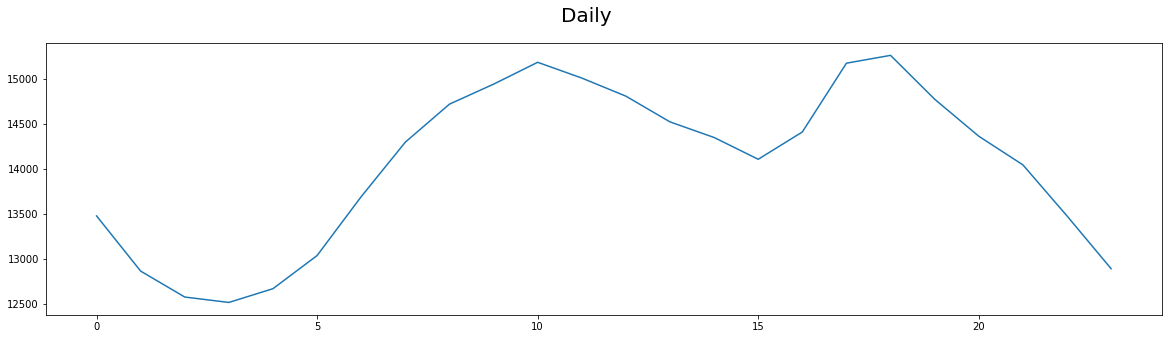

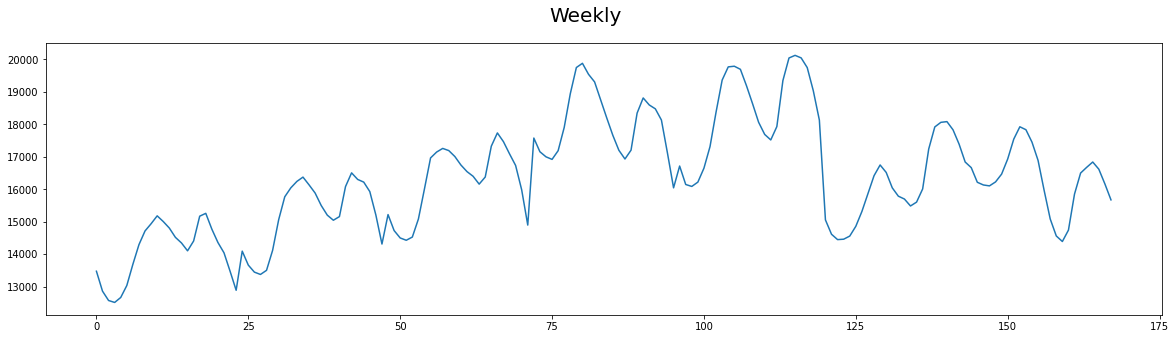

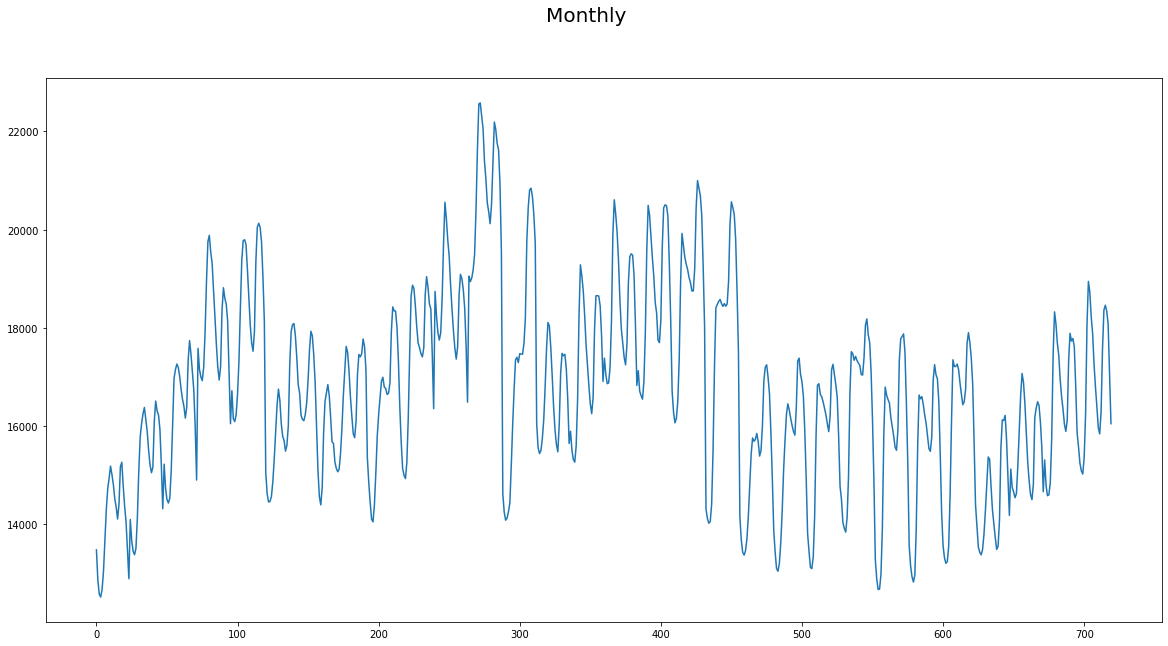

In [6]:
#plot the data loaded to visualize trends
#daily

plt.figure(figsize=(20,5)).suptitle("Daily",fontsize=20)
plt.plot(requests["AEP_MW"].head(24))
plt.show()

#weekly
plt.figure(figsize=(20,5)).suptitle("Weekly",fontsize=20)
plt.plot(requests["AEP_MW"].head(168))
plt.show()

#monthly
plt.figure(figsize=(20,10)).suptitle("Monthly",fontsize=20)
plt.plot(requests["AEP_MW"].head(720))
plt.show()


In [27]:
from sklearn.preprocessing import StandardScaler

#scale the data
print("Request Range before scaling:",min(requests.AEP_MW),max(requests.AEP_MW))
scaler = StandardScaler()
scaled_requests = scaler.fit_transform(requests)
print("Request Range after scaling:",min(scaled_requests),max(scaled_requests))

#Traing data has to be sequential
train_size =80410

#Number of samples to lookback for each sample
#720 default
lookback =720

#sperate training and test data
train_requests = scaled_requests[0:train_size,:]

#Add an additional week for lookback
test_requests = scaled_requests[train_size-lookback:,:]

print("\n Shaped of Train ,Test :", train_requests.shape ,test_requests.shape)



Request Range before scaling: 9581 25695
Request Range after scaling: [-2.28391613] [3.93437215]

 Shaped of Train ,Test : (80410, 1) (41583, 1)


# Build a LSTM model with Keras


In [28]:
#pepare RNN Dataset
def create_rnn_dataset(data, lookback=1):
  
  data_x,data_y = [],[]
  for i in range(len(data)- lookback -1):
    a = data[i:(i + lookback),0]
    data_x.append(a)
    data_y.append(data[i + lookback,0])
  return np.array(data_x),np.array(data_y)

#create x and y for training
train_req_x , train_req_y = create_rnn_dataset(train_requests , lookback)

#Reshape for use with LSTM
train_req_x = np.reshape(train_req_x,(train_req_x.shape[0],1,train_req_x.shape[1]))

print("shapes of x,y:",train_req_x.shape , train_req_y.shape)


shapes of x,y: (79689, 1, 720) (79689,)


In [34]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf


tf.random.set_seed(3)
ts_model =  Sequential()
#Add LSTM
ts_model.add(LSTM(256,input_shape=(1,lookback)))
ts_model.add(Dense(1))
ts_model.compile(loss="mean_squared_error",optimizer="adam",metrics=["mse"])
ts_model.summary()
ts_model.fit(train_req_x, train_req_y, epochs=50, batch_size=1,verbose=1)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 256)               1000448   
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,000,705
Trainable params: 1,000,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79689/79689 [==============================] - 226s 3ms/step - loss: 0.1331 - mse: 0.1331
Epoch 2/50
79689/79689 [==============================] - 224s 3ms/step - loss: 0.0940 - mse: 0.0940
Epoch 3/50
79689/79689 [==============================] - 224s 3ms/step - loss: 0.0827 - mse: 0.0827
Epoch 4/50
79689/79689 [==============================] - 223s 3ms/step - loss: 0.0765 - mse: 0.0765
Epoch 5/50
79689/79689 [===========

# Test the Model

In [35]:
#Preprocess
test_req_x , test_req_y =create_rnn_dataset(test_requests , lookback)
test_req_x = np.reshape(test_req_x,(test_req_x.shape[0],1,test_req_x.shape[1]))
ts_model.evaluate(test_req_x , test_req_y, verbose=1)

#predict for the training dataset
predict_on_train = ts_model.predict(train_req_x)
#Prdeict on the test dataset
predict_on_test = ts_model.predict(test_req_x)

predict_on_train = scaler.inverse_transform(predict_on_train)
predict_on_test = scaler.inverse_transform(predict_on_test)

1277/1277 [==============================] - 4s 3ms/step - loss: 0.0507 - mse: 0.0507


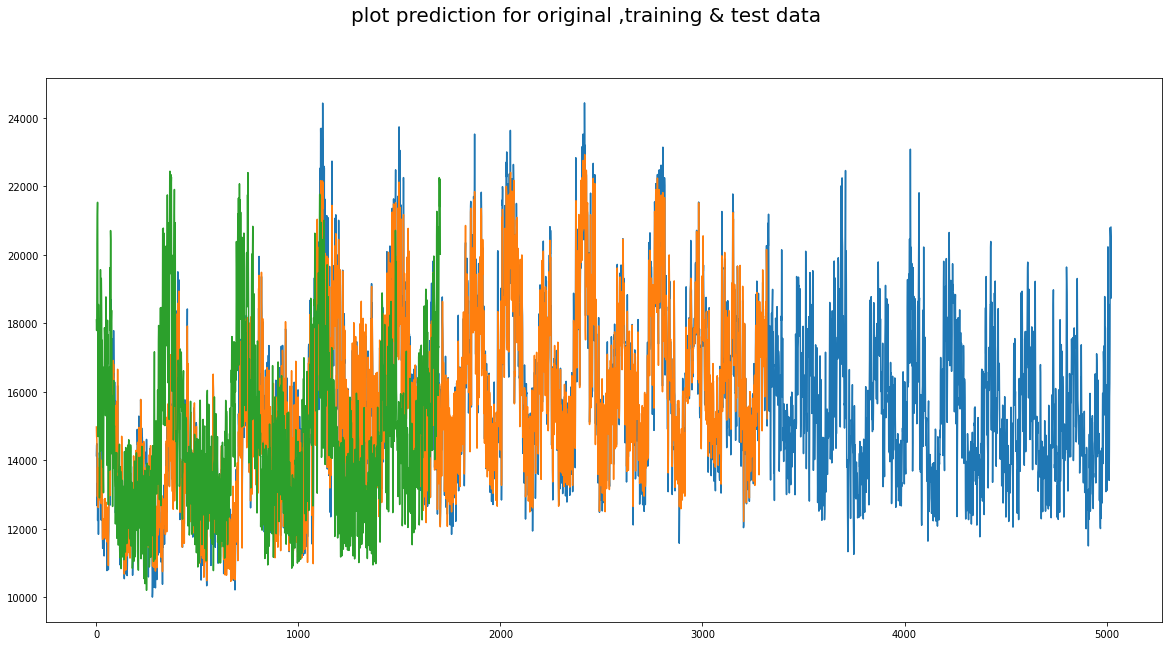

In [36]:
#Plot the predictions

#Total size of plot
total_size = len(predict_on_train)+ len(predict_on_test)

#plot original data 
orig_data =requests.AEP_MW.to_numpy()
orig_data = orig_data.reshape(len(orig_data),1)

#cretae a plot for original data
orig_plot = np.empty((total_size , 1))
orig_plot[:,:] = np.nan
orig_plot[0:total_size,:]= orig_data[lookback:-2,]

#Create a plot for prediction on training
predict_train_plot =np.empty((total_size , 1))
predict_train_plot[:,:] = np.nan
predict_train_plot[0:len(predict_on_train),:] = predict_on_train

#Create a plot for prediction on testing
predict_test_plot =np.empty((total_size , 1))
predict_test_plot[:,:] = np.nan
predict_test_plot[0:len(predict_on_test),:] = predict_on_test

#plot the graphs
plt.figure(figsize=(20,10)).suptitle("plot prediction for original ,training & test data", fontsize=20)
plt.plot(orig_plot[::24])
plt.plot(predict_train_plot[::24])
plt.plot(predict_test_plot[::24])
plt.show()








# Forecasting future Service loads

In [37]:
curr_input = test_req_x[-1,:].flatten()

#Predict for the hours

#loopback is used 
predict_for =24*30

for i in range(predict_for):
  this_input = curr_input[-lookback:]
  this_input = this_input.reshape((1,1,lookback))
  this_prediction = ts_model.predict(this_input)

  curr_input = np.append(curr_input, this_prediction.flatten())
predict_on_future = np.reshape(np.array(curr_input[predict_for:]),(predict_for,1))
predict_on_future=scaler.inverse_transform(predict_on_future)

print(predict_on_future[:5])

[[20255.06026333]
 [20223.57723832]
 [18636.32911848]
 [18002.32183913]
 [17660.80049331]]


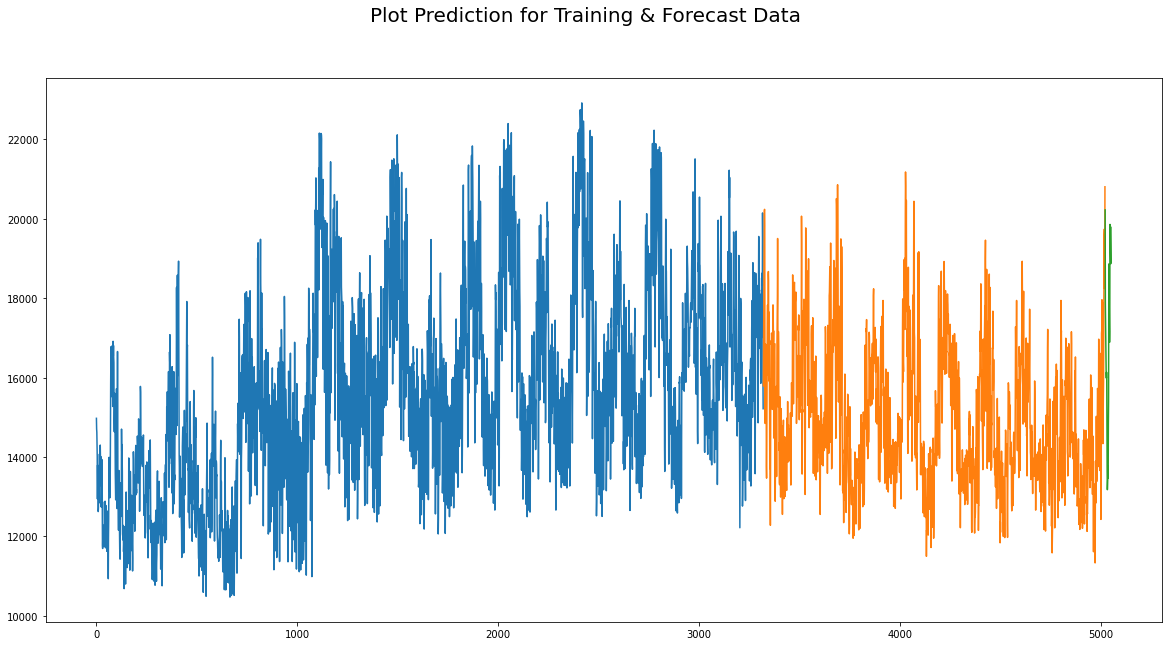

In [38]:
#plot the traunung data with the forcasting data
total_size = len(predict_on_train) + len(predict_on_test) + len(predict_on_future)
                                                                
#setup training chart
predict_train_plot = np.empty((total_size,1))
predict_train_plot[:,:] = np.nan
predict_train_plot[0:len(predict_on_train),:] = predict_on_train 

#setup test chart
predict_test_plot = np.empty((total_size , 1))
predict_test_plot[:,:] = np.nan
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test),:]=predict_on_test

#setup future forecast chart
predict_future_plot = np.empty((total_size,1))
predict_future_plot[:,:]=np.nan
predict_future_plot[len(predict_on_train)+len(predict_on_test):total_size,:]=predict_on_future

plt.figure(figsize=(20,10)).suptitle("Plot Prediction for Training & Forecast Data",fontsize=20)
plt.plot(predict_train_plot[::24])
plt.plot(predict_test_plot[::24])
plt.plot(predict_future_plot[::24])
plt.show()


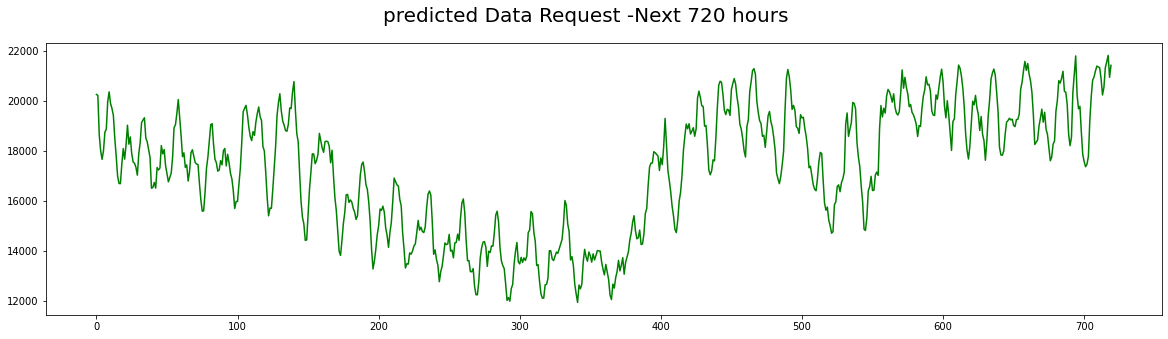

In [39]:
plt.figure(figsize=(20,5)).suptitle("predicted Data Request -Next 720 hours",fontsize=20)
plt.plot(predict_on_future , color='g')
plt.show()

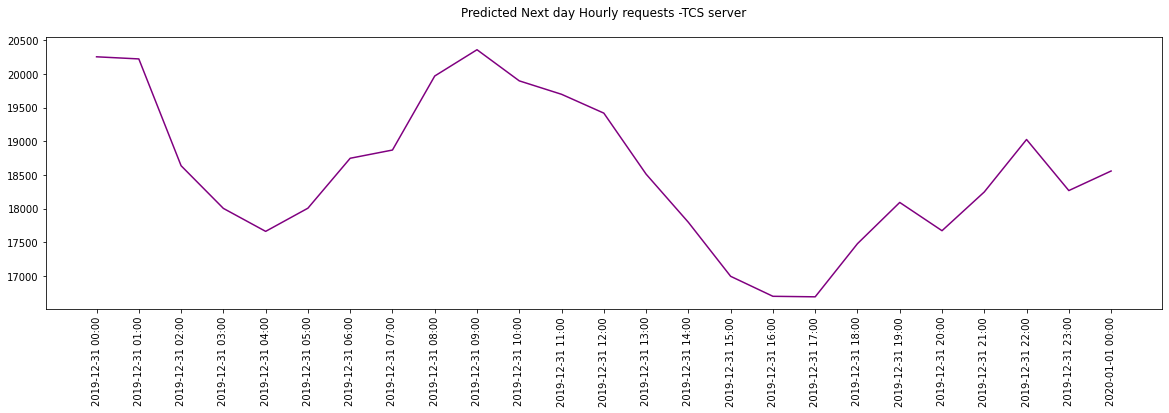

In [40]:
from datetime import datetime , timedelta
def daterange(start_date,end_date):
  delta = timedelta(hours=1)
  while start_date<end_date:
    yield start_date
    start_date += delta

predicted_dates=[]

#input dataset end date upto which dataset is trained and tested and end date isupmost date upto which data is to be predicted -1 year
start_date = datetime(2019,12,31,00,00)
end_date = datetime(2020,12,30,23,59)
for single_date in daterange(start_date ,end_date):
  d=single_date.strftime("%Y-%m-%d %H:%M")
  predicted_dates.append(d)
#print(predicted_dates)

#plotting Day data
y_values = predict_on_future[:25]
fig , ax =plt.subplots(figsize=(20,5))


#Add x-axis and y-axis
ax.plot(y_values , color='purple')

#set title and lable for axes
ax.set(#xlable="Date and Time",
       #ylable="AEP_MW",
       title="Predicted Next day Hourly requests -TCS server\n")
day_points = [x for x in range(25)]
plt.xticks(day_points ,predicted_dates ,rotation='vertical')
plt.show()




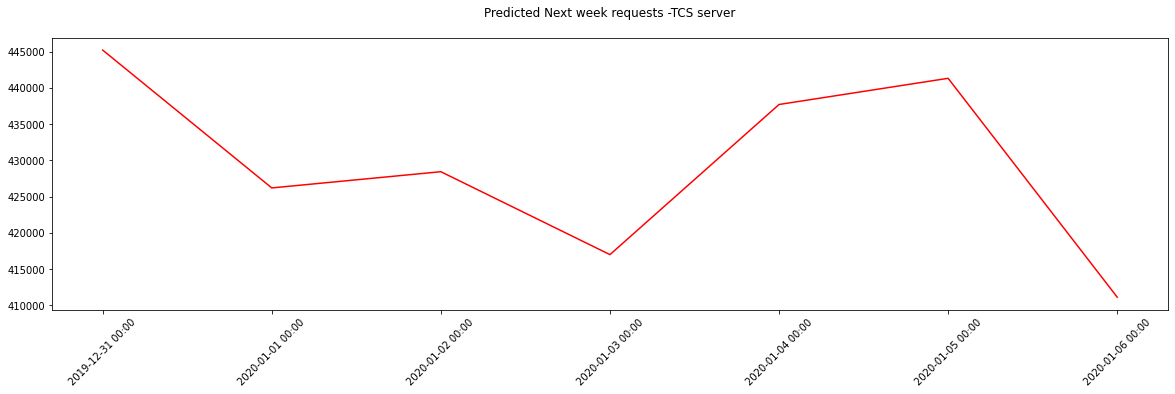

In [41]:
#plotting Weekly data
y_values = predict_on_future[:175]
y_list = [item for sublist in y_values for item in sublist]


total_day_requests=[]
c=0
req_sum=0
for i in range(len(y_list)):
  if c==24:
    c=0
    total_day_requests.append(req_sum)
    req_sum=0
  else:
    req_sum+=y_list[i]
    c+=1

#print(total_day_requets)
fig ,ax =plt.subplots(figsize=(20,5))

#Add x=axis and y-axis

ax.plot(total_day_requests , color='red')

#set title and lable for axes
ax.set(#xlable="Date",
       #ylable="AEP_MW",
       title="Predicted Next week requests -TCS server\n")
week_dates=[]
for i in range(len(predicted_dates)):
  if i%24==0:
    week_dates.append(predicted_dates[i])
week_points=[x for x in range(7)]
plt.xticks(week_points ,week_dates ,rotation ='45')
plt.show()